## Creating Runners Categories
 Clustering data on a collective data set of Boston Marathon 2001 - 2014.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import warnings
warnings.filterwarnings("ignore")
import time

In [5]:
# Load Boston Morathon 2014 for looking at the data set columns
df_2014 = pd.read_csv('Results/2014/results.csv')

pd.set_option('display.max_columns', None)

df_2014.info()
print('\n')
df_2014.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB




,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [7]:
# Load Boston Morathon 2001 for looking at the data set columns
df_2001 = pd.read_csv('Results/2001/results.csv')

pd.set_option('display.max_columns', None)

df_2001.info()
print('\n')
df_2001.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13443 entries, 0 to 13442
Data columns (total 12 columns):
division     13443 non-null object
name         13443 non-null object
city         13443 non-null object
gender       13443 non-null object
age          13443 non-null int64
official     13443 non-null float64
bib          13443 non-null object
overall      13443 non-null object
state        12839 non-null object
genderdiv    13443 non-null object
net          13443 non-null float64
country      13443 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 1.2+ MB




,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
0,2 / 32,"Nietlispach, Franz",Zeiningen,M,43,91.37,W1,2 / 35,NaN,2 / 29,91.37,SUI
1,1 / 3254,"Ndereba, Catherine",Nairobi,F,28,143.88,F1,27 / 13408,NaN,1 / 4814,143.88,KEN
2,15 / 3945,"Lagat, Elijah",Nandi District,M,34,137.98,1,17 / 13408,NaN,17 / 8594,137.98,KEN
3,14 / 3945,"Abera, Gezahegne",Addis Ababa,M,22,137.07,2,16 / 13408,NaN,16 / 8594,137.07,ETH
4,3 / 32,"Frei, Heinz",Etziken,M,43,91.97,W2,3 / 35,NaN,3 / 29,91.97,SUI


As we can see the 2014 dataset contains more features than the 2001 dataset. Also values of some common features are dofferent in their format. 

In [8]:
# Gathering common columns of years 2001 - 2014 in a unique data set
years = []
for year in range(2001, 2015):
    y = pd.read_csv('Results/{}/results.csv'.format(year), na_values="-")[['gender', 'age', 'official']]
    y['year'] = str(year)
    years.append(y)
df_years = pd.concat(years, ignore_index=True).dropna()

<Figure size 18000x720 with 0 Axes>

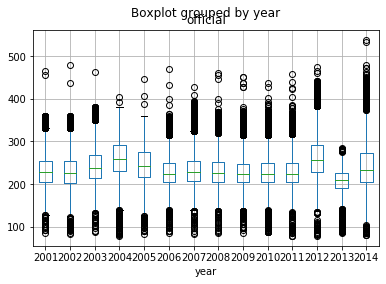

In [27]:
plt.figure(figsize=(250, 10))
df_years.boxplot(column='official', by='year')
plt.show()

Now we pick the year 2014 and perform clustering on performance data from the Boston marathon.<br>
Boston Marathon is open to men and women, though they are separated into different divisions. 
## Data Visalization and Exploration

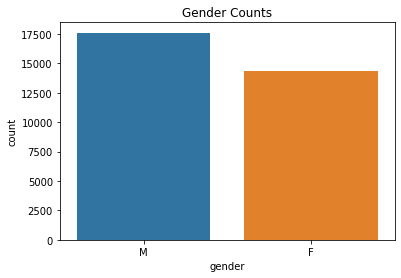

M    17617
F    14367
Name: gender, dtype: int64

In [29]:
# View value counts.
sns.countplot('gender', data=df_2014)
plt.title('Gender Counts')
plt.show()
pd.value_counts(df_2014['gender'])

There are totally 31984 observations with 21 features. Except for gender, most categorical features do not contain computing information, but most numeric features contain information about runners performance wich will be effective in our clustering model. 

In [31]:
print(df_2014.dtypes)

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object


Because gender is important, we keep it and drop the rest of categorical features. We can easily convert gender to numeric values for computation purpose.  

In [35]:
# Convert male/female to 1/0 and gender column name
df_2014 = df_2014.rename(columns = {'gender':'is_male'})
df_2014['is_male'].replace(('F', 'M'), (0, 1), inplace=True)

In [43]:
# Drop categorical features
categorical = ['name', 'bib','ctz','state','country','city']
df_2014 = df_2014.drop(categorical, axis=1)

In [52]:
# Change dtypes from 'object' to 'floatt64'
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df_2014[cols] = df_2014[cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
df_2014.dtypes

10k          float64
division       int64
25k          float64
is_male        int64
age            int64
official     float64
genderdiv      int64
35k          float64
overall        int64
pace         float64
30k          float64
5k           float64
half         float64
20k          float64
40k          float64
dtype: object

In [53]:
# Drop all rows that contain NaN values
numeric = ['10k', 'division', '25k', 'is_male', 'age', 'official', 'genderdiv', '35k', 'overall', 'pace', '30k', '5k', 'half',
           '20k', '40k']
df_2014 = df_2014.dropna(subset = numeric)

## Setting up input variables and grouping sets
Now, to evaluate our various clustering solutions, we need to split our data into 4 subsets so we can compare them against eachother for consistency. We will also normalize the data so we can use PCA to reduce it to 2 components for visualization purposes.

In [58]:
X = df_2014
rows = X.shape[0] - X.shape[0] % 4
X = X.iloc[:rows, :]
X_norm = normalize(X)
print(X.shape)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

(31648, 15)


# K-means & Plotting

scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097


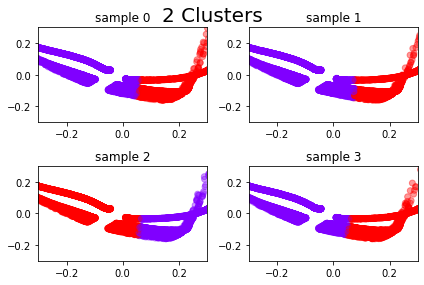



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580


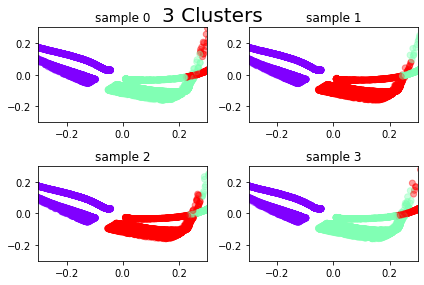



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009


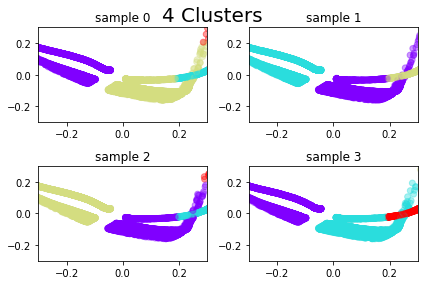



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892


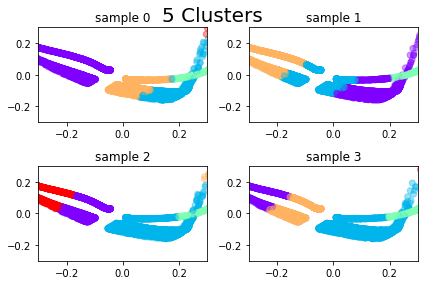



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008


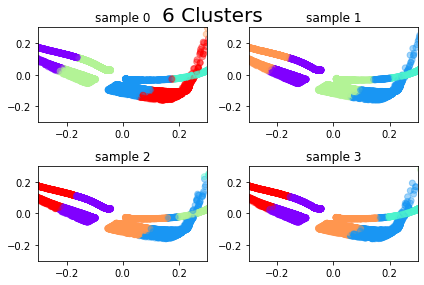



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477


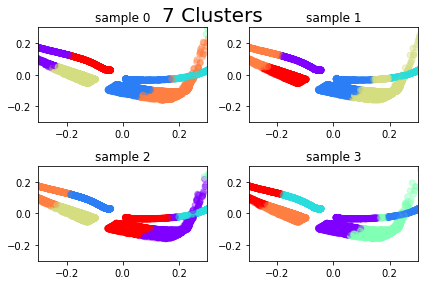



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232


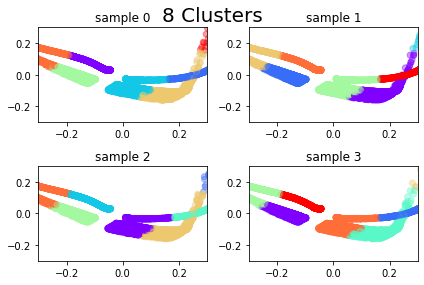



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363


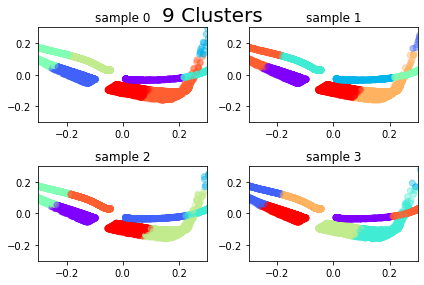



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363
8      10.0    0.553931  0.006278


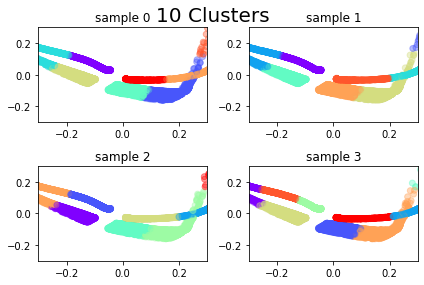



scores:
   clusters  mean score       std
0       2.0    0.454315  0.007097
1       3.0    0.477944  0.003580
2       4.0    0.495246  0.002009
3       5.0    0.437714  0.023892
4       6.0    0.450663  0.003008
5       7.0    0.527788  0.003477
6       8.0    0.533154  0.002232
7       9.0    0.558038  0.001363
8      10.0    0.553931  0.006278
9      11.0    0.555869  0.001732


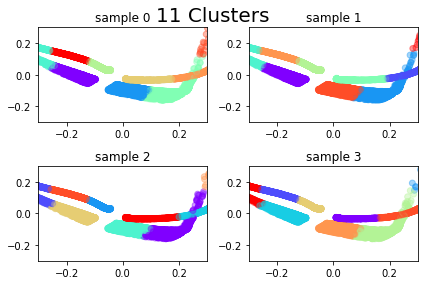



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099


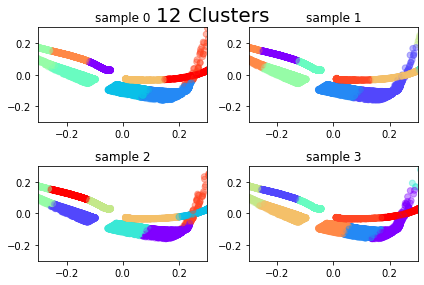



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397


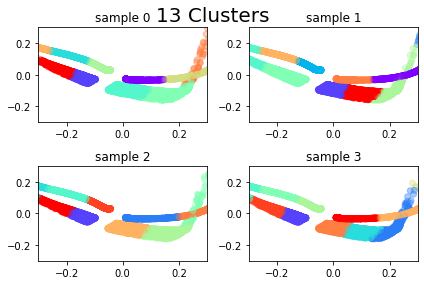



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920


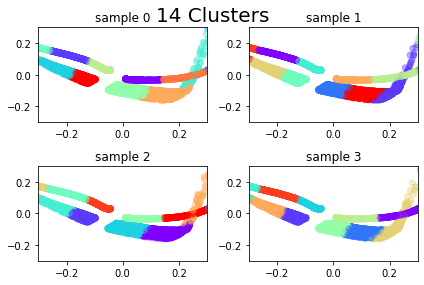



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101


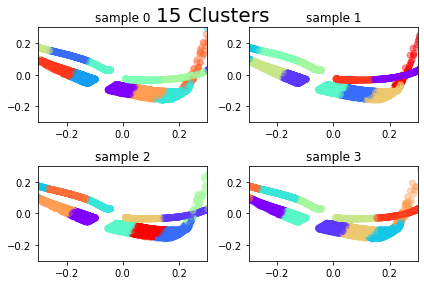



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119


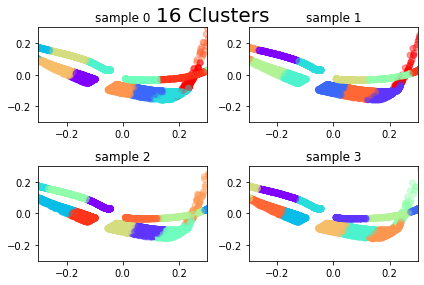



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.537418  0.009078


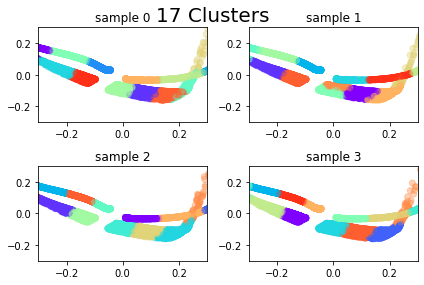



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.537418  0.009078
16      18.0    0.533278  0.017180


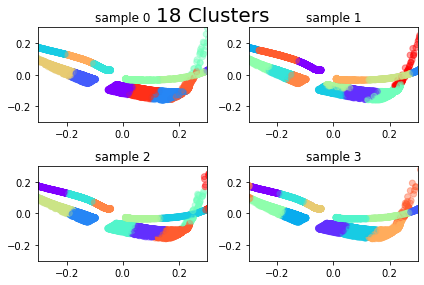



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.537418  0.009078
16      18.0    0.533278  0.017180
17      19.0    0.529320  0.008982


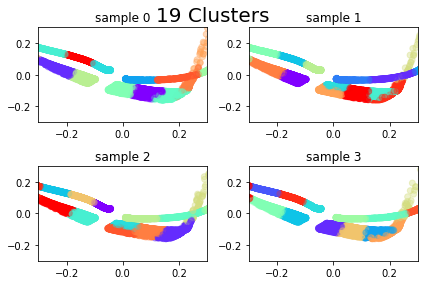



scores:
    clusters  mean score       std
0        2.0    0.454315  0.007097
1        3.0    0.477944  0.003580
2        4.0    0.495246  0.002009
3        5.0    0.437714  0.023892
4        6.0    0.450663  0.003008
5        7.0    0.527788  0.003477
6        8.0    0.533154  0.002232
7        9.0    0.558038  0.001363
8       10.0    0.553931  0.006278
9       11.0    0.555869  0.001732
10      12.0    0.555241  0.011099
11      13.0    0.549027  0.012397
12      14.0    0.548840  0.012920
13      15.0    0.544838  0.003101
14      16.0    0.545541  0.002119
15      17.0    0.537418  0.009078
16      18.0    0.533278  0.017180
17      19.0    0.529320  0.008982
18      20.0    0.523120  0.001375


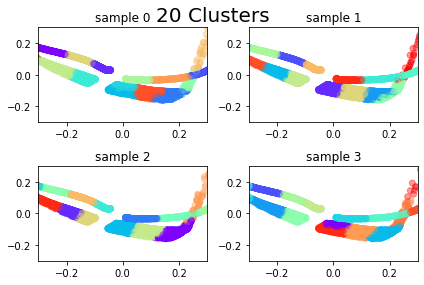



sorted cluster scores:


AttributeError: 'DataFrame' object has no attribute 'sort'

In [63]:
def evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, clust_range):

    plot_clusters = pd.DataFrame()
    cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])

    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        for nclust in range(2, clust_range):
            km = KMeans(n_clusters=nclust, random_state=42)
            km.fit(data[0])
            labels = km.labels_
            cluster_pred = km.predict(data[0])
            plot_clusters['clust' + str(nclust) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')

    for nclust in range(2, clust_range):

        colors = cm.rainbow(np.linspace(0, 1, nclust))
        f, plotgrid = plt.subplots(2, 2)
        sil_scores = []

        for i in range(4):

            current_group = (f'clust{nclust}_sample{i}')

            x_plot = plot_clusters[f'pca_f1_sample{i}']
            y_plot = plot_clusters[f'pca_f2_sample{i}']

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'sample {i}')
            plotgrid[rows, cols].set_xlim([-.3, .3])
            plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score_' + str(current_group)].mean()
            sil_scores.append(sil_score)

        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('scores:')
        print(cluster_scores)

        plt.suptitle(f'{nclust} Clusters', fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('sorted cluster scores:')
    sorted_scores = cluster_scores.sort(columns = 'mean score', ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num
    
df_2014_best_cluster_num = evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, 21)